# Utilize `healsparse` to plot cell-coadd statistics

A notebook to plot summary statistics of cell-based coadds, e.g. magnitude depth, variance, input images etc. onto sky plots

Last working stack: `d_2024_08_27`

## Load imports and data

In [1]:
REPO = '/sdf/data/rubin/repo/main/'

from lsst.daf.butler import Butler
import lsst.afw.image as afwImage
from lsst.skymap import Index2D
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import healsparse as hsp
import healpy as hp
import lsst.geom as afwGeom
import skyproj

from lsst.sphgeom import Box, HealpixPixelization

# using statsCtrl
from lsst.drp.tasks.assemble_cell_coadd import AssembleCellCoaddTask
import lsst.afw.math as afwMath

%matplotlib inline

butler = Butler(REPO)
registry = butler.registry

In [2]:
collection = 'u/mgorsuch/cell_coadds_tract_9813_d_2024_08_27/20240904T143002Z'

In [3]:
# create and configure stats control object as seen in assemble_cell_coadd task
statsCtrl = afwMath.StatisticsControl()
statsCtrl.setAndMask(afwImage.Mask.getPlaneBitMask(("BAD", "NO_DATA", "SAT"))) # use default PlaneBitMasks from task
statsCtrl.setNanSafe(True)

In [4]:
# plot parameters
rcparams = {'xtick.labelsize': 10,
            'ytick.labelsize': 10,
            'axes.labelsize': 10,
            'axes.linewidth': 5,}

In [5]:
# define healpix parameters
nside_coverage = 2**8
nside_sparse = 2**13

pixelization = HealpixPixelization(hp.nside2order(nside_sparse))

## Start with a single patch for simplicity

In [42]:
patch = 50

In [43]:
coadd = butler.get('deepCoaddCell', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = 9813, 
                     patch=patch,
                     band='i',)

In [44]:
# list of cells using their Index2D information
cell_list = list(coadd.cells.keys()) # skips indices that are empty, fixed below

### WCS for cells

Get the WCS information from the coadd

In [45]:
# define a wcs from the given coadd
wcs = coadd.wcs

Example of taking a pixel coordinate and getting WCS coordinates.

In [46]:
sky_coord = wcs.pixelToSky(afwGeom.Point2D(0, 0))
print(sky_coord)

(151.0180218631, +1.4613660181)


Check that cells contain active WCS information (aka just check that they aren't the same)

In [47]:
cell = coadd.cells[cell_list[0]]
cell_other = coadd.cells[cell_list[1]]

In [48]:
cell_center = cell.outer.bbox.getCenter()
cell_center_coord = wcs.pixelToSky(cell_center)
print(cell_center, cell_center_coord)

(17924, 11924) (150.1813697634, +2.0179279192)


In [49]:
cell_center2 = cell_other.outer.bbox.getCenter()
cell_center_coord2 = wcs.pixelToSky(cell_center2)
print(cell_center2, cell_center_coord2)

(18074, 11924) (150.1743654788, +2.0179276178)


Are the distances reasonable, given the size of cells? (~30.91" on a side for inner cells)

In [50]:
# define inner and outer bbox for reference
outer_bbox = cell.outer.bbox
inner_bbox = cell.inner.bbox

In [51]:
# get the four corner coordinates of the cell, both for inner and outer boundaries
outer_corners = [wcs.pixelToSky(outer_bbox.beginX, outer_bbox.beginY),
                 wcs.pixelToSky(outer_bbox.beginX, outer_bbox.endY),
                 wcs.pixelToSky(outer_bbox.endX, outer_bbox.beginY),
                 wcs.pixelToSky(outer_bbox.endX, outer_bbox.endY),]

inner_corners = [wcs.pixelToSky(inner_bbox.beginX, inner_bbox.beginY),
                 wcs.pixelToSky(inner_bbox.beginX, inner_bbox.endY),
                 wcs.pixelToSky(inner_bbox.endX, inner_bbox.beginY),
                 wcs.pixelToSky(inner_bbox.endX, inner_bbox.endY),]

In [52]:
print("Outer RA length: ", outer_corners[0].getRa().asArcseconds()-outer_corners[3].getRa().asArcseconds())
print("Inner RA length: ", inner_corners[0].getRa().asArcseconds()-inner_corners[3].getRa().asArcseconds())
print("Outer DEC length: ", outer_corners[0].getDec().asArcseconds()-outer_corners[3].getDec().asArcseconds())
print("Inner DEC length: ", inner_corners[0].getDec().asArcseconds()-inner_corners[3].getDec().asArcseconds())

Outer RA length:  42.027615871978924
Inner RA length:  25.21656957885716
Outer DEC length:  -41.997669598076754
Inner DEC length:  -25.198601898262496


The 25" seems a little low for my estimate of inner cell size, but it is in the ballpark.

### Collect cell information 

Need the RA, DEC of each cell center, as well as information of interest e.g. input counts, cell depth, cell variance

In [53]:
# collect cell info
cell_df_small = pd.DataFrame()
pixel_indices = []
inputs_list = []

# for each cell in cell_list:
for cell in cell_list:
    cell_bbox = coadd.cells[cell].inner.bbox
    begin_coord = wcs.pixelToSky(cell_bbox.beginX, cell_bbox.beginY)
    end_coord = wcs.pixelToSky(cell_bbox.endX, cell_bbox.endY)
    
    if begin_coord.getRa() < end_coord.getRa():
        ra1 = begin_coord.getRa().asDegrees()
        ra2 = end_coord.getRa().asDegrees()
    else:
        ra1 = end_coord.getRa().asDegrees()
        ra2 = begin_coord.getRa().asDegrees()
    
    if begin_coord.getDec() < end_coord.getDec():
        dec1 = begin_coord.getDec().asDegrees()
        dec2 = end_coord.getDec().asDegrees()
    else:
        dec1 = end_coord.getDec().asDegrees()
        dec2 = begin_coord.getDec().asDegrees()
    
    coords = [ra1, dec1, ra2, dec2] # low ra, low dec, high ra, high dec
 
    box = Box.fromDegrees(*coords)
    rs = pixelization.envelope(box) # range set
    
    indices = []
    for (begin, end) in rs:
        indices.extend(range(begin, end))
    
    inputs_list.append(coadd.cells[cell].visit_count)
    pixel_indices.append(indices)

cell_df_small["inputs"] = inputs_list
cell_df_small["pixels"] = pixel_indices

For each pixel, we want all contributing cells that overlap the pixel, then average their information of interest. 

At this point, all overlapping cells contribute the same amount to each pixel.

In [54]:
# get list of all unique pixels that have cells overlapping
pixels = cell_df_small["pixels"].explode().unique()

input_averages = []
for pixel in pixels:
    # pick out cells that contain this pixel
    pixel_cells = cell_df_small[pd.DataFrame(cell_df_small.pixels.tolist()).isin([pixel]).any(axis=1).values]
    input_averages.append(pixel_cells['inputs'].mean())

### Generate a `healsparse` map

In [55]:
hsp_map_test = hsp.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.float64)
hsp_map_test.update_values_pix(np.array(pixels, dtype=np.int64), np.array(input_averages))

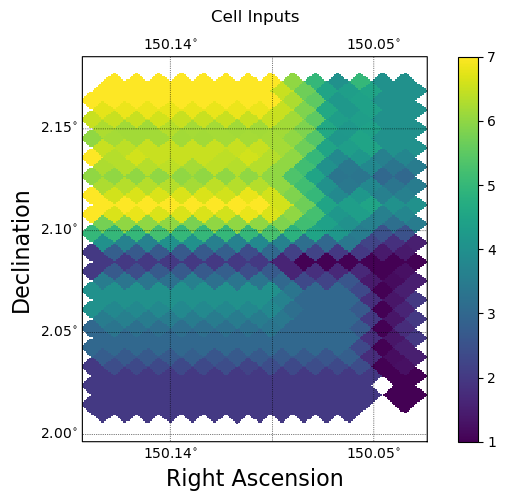

In [56]:
fig, ax = plt.subplots(figsize=(8, 5))
sp = skyproj.GnomonicSkyproj(ax=ax, lon_0=150.1, lat_0=2.1, min_lon_ticklabel_delta=0.2)
sp.draw_hspmap(hsp_map_test)
plt.title("Cell Inputs", pad=25)
plt.colorbar()
plt.show()

## Plot Multiple Patches

Get the number of patches available in this collection.

In [21]:
tract = 9813

patches = []
# look for deepCoaddCell objects rather than input warps
# since some patches may fail and not produce coadds, but still have all warps in collection
for ref in butler.registry.queryDatasets('deepCoaddCell',
                                         physical_filter='HSC-I',
                                         collections=collection,
                                         instrument='HSC',
                                         skymap = 'hsc_rings_cells_v1',
                                         where=f'tract={tract}'):
    patches.append(ref.dataId.get('patch'))
patches = np.unique(patches)

In [22]:
# method find the pixel indices that overlap the sky projection of the cell area
def get_cell_pixels(cell, wcs):
    cell_bbox = cell.inner.bbox
    begin_coord = wcs.pixelToSky(cell_bbox.beginX, cell_bbox.beginY)
    end_coord = wcs.pixelToSky(cell_bbox.endX, cell_bbox.endY)
    
    if begin_coord.getRa() < end_coord.getRa():
        ra1 = begin_coord.getRa().asDegrees()
        ra2 = end_coord.getRa().asDegrees()
    else:
        ra1 = end_coord.getRa().asDegrees()
        ra2 = begin_coord.getRa().asDegrees()
    
    if begin_coord.getDec() < end_coord.getDec():
        dec1 = begin_coord.getDec().asDegrees()
        dec2 = end_coord.getDec().asDegrees()
    else:
        dec1 = end_coord.getDec().asDegrees()
        dec2 = begin_coord.getDec().asDegrees()
    
    coords = [ra1, dec1, ra2, dec2] # low ra, low dec, high ra, high dec

    box = Box.fromDegrees(*coords)
    rs = pixelization.envelope(box) # range set
    
    indices = []
    for (begin, end) in rs:
        indices.extend(range(begin, end))
    
    return indices

In [23]:
# method for getting a single variance value for a cell
def get_cell_variance(cell):
    var_array = cell.inner.variance.array

    # mask cells with only inf/-inf variance
    if (len(var_array[np.isfinite(var_array)]) == 0):
        return np.nan

    median_var = np.median(var_array[np.isfinite(var_array)])

    return median_var

In [24]:
# returns the limiting PSF magnitude of each pixel, given the cell object and statistics settings
def get_mag_lim(cell, statsCtrl, zp=27, num_sigma=5):
    
    # get psf area of cell
    psf_im = cell.psf_image.array
    numer = np.square(np.sum(psf_im))
    # numer = 1 # I've seen this as well, but said to be prone to changing if stamp size changes
    denom = np.sum(np.square(psf_im))
    psf_area = numer/denom

    # get total cell weight
    accTask = AssembleCellCoaddTask()
    mask_im = cell.outer.asMaskedImage()
    computed_weight = accTask._compute_weight(mask_im, statsCtrl)
    # the computed weight will be the same value for each pixel
    total_weight = computed_weight * mask_im.getDimensions()[0] * mask_im.getDimensions()[1]
    
    maglim = zp-2.5*np.log10(num_sigma*np.sqrt(psf_area/total_weight))
    
    return maglim

In [25]:
# collect cell info
cell_df = pd.DataFrame()
pixel_indices = []
inputs_list = []
variance_list = []
mag_depth_list = []

segs = [] # collection of lines to plot patch outlines

for patch in patches:
    
    coadd = butler.get('deepCoaddCell', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = 9813, 
                     patch=patch,
                     band='i',)

    # define a wcs from the given coadd
    wcs = coadd.wcs

    # get coadd outline
    coadd_corners = coadd.inner_bbox.getCorners()

    for index, corner in enumerate(coadd_corners):
        corner_coord_start = wcs.pixelToSky(corner.getX(), corner.getY())
        if index < 3:
            corner_coord_end = wcs.pixelToSky(coadd_corners[index+1].getX(), coadd_corners[index+1].getY())
        else:
            corner_coord_end = wcs.pixelToSky(coadd_corners[0].getX(), coadd_corners[0].getY())

        start_ra = corner_coord_start[0].asDegrees()
        start_dec = corner_coord_start[1].asDegrees()

        end_ra = corner_coord_end[0].asDegrees()
        end_dec = corner_coord_end[1].asDegrees()

        segs.append(((start_ra, start_dec), (end_ra, end_dec)))
    
    cell_list = list(coadd.cells.keys()) # skips indices that are empty

    # for each cell in cell_list:
    for index, cell_index in enumerate(cell_list):

        cell = coadd.cells[cell_index]
    
        pixel_indices.append(get_cell_pixels(cell, wcs))
        
        inputs_list.append(cell.visit_count)
        variance_list.append(get_cell_variance(cell))
        mag_depth_list.append(get_mag_lim(cell, statsCtrl))

    del coadd

cell_df["pixels"] = pixel_indices
cell_df["inputs"] = inputs_list
cell_df["variance"] = variance_list
cell_df["depth"] = mag_depth_list

In [26]:
cell_df = cell_df.drop_duplicates(subset=['pixels']) # remove overlapping cells

In [27]:
# get list of all unique pixels that have cells overlapping
pixels = cell_df["pixels"].explode().unique()

input_mean = []
variance_mean = []
depth_mean = []

for pixel in pixels:
    # pick out cells that contain this pixel
    pixel_cells = cell_df[pd.DataFrame(cell_df.pixels.tolist()).isin([pixel]).any(axis=1).values]
    input_mean.append(pixel_cells['inputs'].mean())
    variance_mean.append(pixel_cells['variance'].mean())
    depth_mean.append(pixel_cells['depth'].mean())

#### Input Map

In [28]:
hsp_map_input = hsp.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.float64)
hsp_map_input.update_values_pix(np.array(pixels, dtype=np.int64), np.array(input_mean))

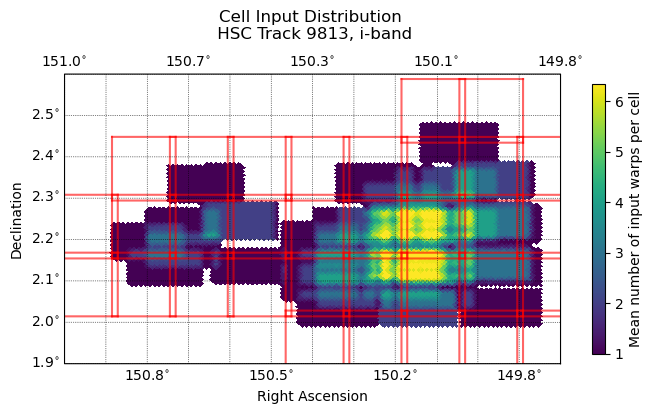

In [29]:
fig, ax = plt.subplots(figsize=(8, 5))
sp = skyproj.GnomonicSkyproj(ax=ax, lon_0=150.1, lat_0=2.1, min_lon_ticklabel_delta=0.2, rcparams=rcparams)
sp.draw_hspmap(hsp_map_input)
for seg in segs:
    sp.plot([seg[0][0], seg[1][0]], [seg[0][1], seg[1][1]], 'r-', alpha=0.6)
plt.title(f"Cell Input Distribution \n HSC Track 9813, i-band", pad=25)
plt.colorbar(shrink=0.7, label='Mean number of input warps per cell')
sp.set_extent([149.8, 151, 1.9, 2.6])
plt.savefig('image_outputs/cell-inputs-track-9813.png', bbox_inches='tight')
plt.show()

#### Variance Map

In [30]:
hsp_map_var = hsp.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.float32)
hsp_map_var.update_values_pix(np.array(pixels, dtype=np.int64), np.array(variance_mean))

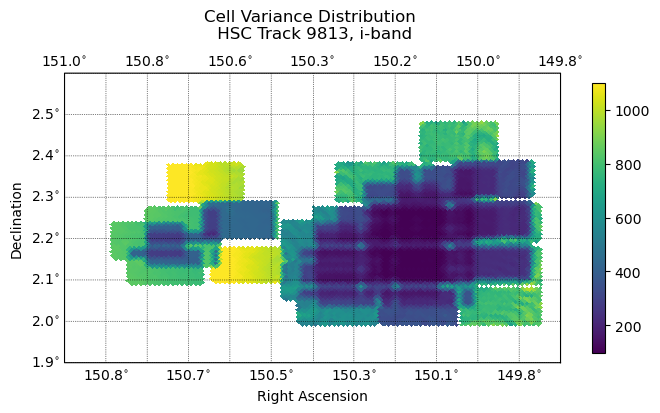

In [31]:
fig, ax = plt.subplots(figsize=(8, 5))

sp = skyproj.GnomonicSkyproj(ax=ax, lon_0=150.4, lat_0=2.2, rcparams=rcparams)

sp.draw_hspmap(hsp_map_var)
sp.set_extent([149.8, 151, 1.9, 2.6])
plt.colorbar(shrink=0.7)
plt.title(f"Cell Variance Distribution \n HSC Track 9813, i-band", pad=25)
plt.savefig('image_outputs/cell-variance-track-9813.png', bbox_inches='tight')
plt.show()

#### Depth Map

In [32]:
hsp_map_depth = hsp.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.float64)
hsp_map_depth.update_values_pix(np.array(pixels, dtype=np.int64), np.array(depth_mean))

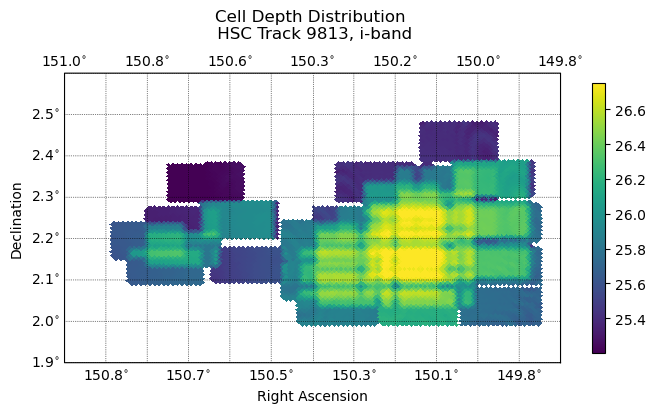

In [33]:
fig, ax = plt.subplots(figsize=(8, 5))

sp = skyproj.GnomonicSkyproj(ax=ax, lon_0=150.4, lat_0=2.2, rcparams=rcparams)

sp.draw_hspmap(hsp_map_depth)
sp.set_extent([149.8, 151, 1.9, 2.6])
plt.colorbar(shrink=0.7)
plt.title(f"Cell Depth Distribution \n HSC Track 9813, i-band", pad=25)
plt.savefig('image_outputs/cell-depth-track-9813.png', bbox_inches='tight')
plt.show()

## Mask Fractions

For simplicity, this can live in its own dataframe, given the complication of looping over individual visits for each cell.

In [34]:
accTask = AssembleCellCoaddTask()

intrp = afwImage.Mask.getPlaneBitMask("INTRP")

cell_df_mask = pd.DataFrame()

pixel_indices = [[[[] for k in range(22)] for j in range(22)] for i in range(len(patches))]
weighted_mask_frac_05 = [[[0 for k in range(22)] for j in range(22)] for i in range(len(patches))]
warp_inputs = [[[0 for k in range(22)] for j in range(22)] for i in range(len(patches))]
total_inputs = [[[0 for k in range(22)] for j in range(22)] for i in range(len(patches))]
total_weights = [[[0 for k in range(22)] for j in range(22)] for i in range(len(patches))] # for normalizing

for patch_index, patch in enumerate(patches):
    
    # coadd info is not dependent on visits
    coadd = butler.get('deepCoaddCell', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = 9813, 
                     patch=patch,
                     band='i',)

    cell_list = list(coadd.cells.keys()) # skips indices that are empty

    wcs = coadd.wcs

    # get the visits from a single patch
    visits = []
    for ref in butler.registry.queryDatasets('deepCoadd_directWarp',
                                             physical_filter='HSC-I',
                                             collections=collection,
                                             instrument='HSC',
                                             skymap = 'hsc_rings_cells_v1',
                                             tract=9813,
                                             patch=patch):
        visits.append(ref.dataId.get('visit'))
    visits = np.unique(visits)

    for visit_index, visit in enumerate(visits):

        warp = butler.get('deepCoadd_directWarp',
                       collections = collection,
                       instrument='HSC',
                       skymap = 'hsc_rings_cells_v1',
                       tract = 9813,
                       patch = patch,
                       visit = visit)
    
        mask_frac_warp = butler.get('deepCoadd_directWarp_maskedFraction',
                       collections = collection,
                       instrument='HSC',
                       skymap = 'hsc_rings_cells_v1',
                       tract = 9813,
                       patch = patch,
                       visit = visit)

        # for each cell in cell_list:
        for index, cell_index in enumerate(cell_list):
            
            cell = coadd.cells[cell_index]

            x_index = cell_index.x
            y_index = cell_index.y

            # avoid reassigning pixels and inputs to cells for each visit
            if visit_index==0:
                pixel_indices[patch_index][y_index][x_index].append(get_cell_pixels(cell, wcs))
                total_inputs[patch_index][y_index][x_index] = cell.visit_count
                
            bbox = cell.outer.bbox
            masked_im = warp[bbox].getMaskedImage()
            mask_frac_im = mask_frac_warp[bbox].array

            # check if cell uses warp, skip cell if not
            cell_inputs = list(cell.inputs)
            cell_visits = [input.visit for input in cell_inputs]
            if not (np.isin(visit, cell_visits)):
                continue

            # skip warp for this cell if intrp mask fraction is too high
            total_pixels = bbox.area
            mask_frac = np.nansum(mask_frac_im[np.where(np.isfinite(mask_frac_im))])/total_pixels

            if mask_frac >= 0.05:
                continue

            # coadd the weighted mask fraction for this cell
            input_weight = accTask._compute_weight(masked_im, statsCtrl)
            total_weights[patch_index][y_index][x_index] += input_weight
            weight_mask_frac = input_weight * mask_frac_im

            weighted_mask_frac_05[patch_index][y_index][x_index] += np.nansum(weight_mask_frac) / total_pixels

            warp_inputs[patch_index][y_index][x_index] += 1

        del warp, mask_frac_warp
    del coadd

pixel_indices = [x for xss in pixel_indices for xs in xss for x in xs]
weighted_mask_frac_05 = np.array([x for xss in weighted_mask_frac_05 for xs in xss for x in xs])
total_weights = np.array([x for xss in total_weights for xs in xss for x in xs])
weighted_mask_frac_05 = weighted_mask_frac_05 / total_weights
warp_inputs = np.array([x for xss in warp_inputs for xs in xss for x in xs])
total_inputs = np.array([x for xss in total_inputs for xs in xss for x in xs])
input_fraction = warp_inputs / total_inputs

/tmp/ipykernel_16530/582508202.py:103: RuntimeWarning: invalid value encountered in divide
  weighted_mask_frac_05 = weighted_mask_frac_05 / total_weights
/tmp/ipykernel_16530/582508202.py:106: RuntimeWarning: invalid value encountered in divide
  input_fraction = warp_inputs / total_inputs


In [35]:
cell_df_mask['pixels'] = pixel_indices
cell_df_mask['weighted_mask_frac_05'] = weighted_mask_frac_05
cell_df_mask['warp_inputs'] = warp_inputs
cell_df_mask['total_inputs'] = total_inputs
cell_df_mask['input_fraction'] = input_fraction

In [36]:
cell_df_mask = cell_df_mask.drop(cell_df_mask[cell_df_mask.total_inputs == 0].index) # drop cells with zero inputs
cell_df_mask = cell_df_mask.drop_duplicates(subset=['pixels']) # remove overlapping cells

In [37]:
# get list of all unique pixels that have cells overlapping
pixels_mask = cell_df_mask["pixels"].explode().explode().unique()

mask_frac_05_mean = []
warp_inputs_mean = []
total_inputs_mean = []
input_fraction_mean = []

for pixel in pixels_mask:
    # pick out cells that contain this pixel
    pixel_list = [x for list_0 in cell_df_mask['pixels'].tolist() for x in list_0] # get rid of extra bracket
    pixel_cells = cell_df_mask[pd.DataFrame(pixel_list).isin([pixel]).any(axis=1).values]

    mask_frac_05_mean.append(pixel_cells['weighted_mask_frac_05'].mean())
    warp_inputs_mean.append(pixel_cells['warp_inputs'].mean())
    total_inputs_mean.append(pixel_cells['total_inputs'].mean())
    input_fraction_mean.append(pixel_cells['input_fraction'].mean())

#### Input fraction map

In [38]:
hsp_map_frac = hsp.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.float64)
hsp_map_frac.update_values_pix(np.array(pixels_mask, dtype=np.int64), np.array(input_fraction_mean))

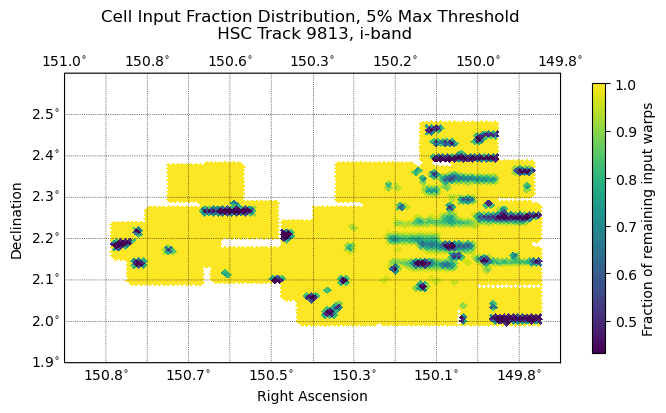

In [39]:
fig, ax = plt.subplots(figsize=(8, 5))

sp = skyproj.GnomonicSkyproj(ax=ax, lon_0=150.4, lat_0=2.2, rcparams=rcparams)

sp.draw_hspmap(hsp_map_frac)
sp.set_extent([149.8, 151, 1.9, 2.6])
plt.colorbar(shrink=0.7, label='Fraction of remaining input warps')
plt.title(f"Cell Input Fraction Distribution, 5% Max Threshold \n HSC Track 9813, i-band", pad=25)
plt.savefig('image_outputs/cell-input-fraction-track-9813.png', bbox_inches='tight')
plt.show()

#### Weighted Mask Fraction Map

In [40]:
hsp_map_mask_frac = hsp.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.float64)
hsp_map_mask_frac.update_values_pix(np.array(pixels_mask, dtype=np.int64), np.array(mask_frac_05_mean))

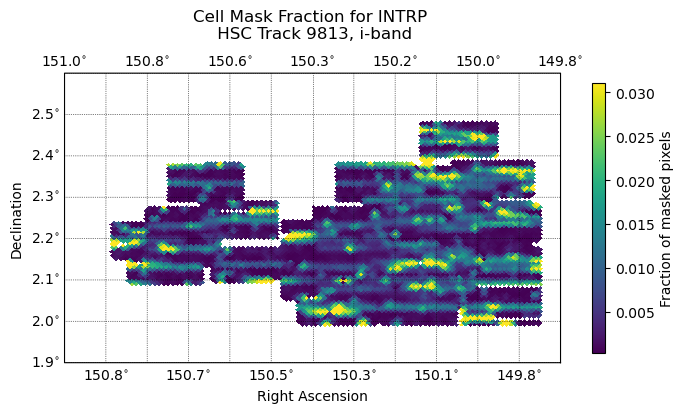

In [41]:
fig, ax = plt.subplots(figsize=(8, 5))

sp = skyproj.GnomonicSkyproj(ax=ax, lon_0=150.4, lat_0=2.2, rcparams=rcparams)

sp.draw_hspmap(hsp_map_mask_frac)
sp.set_extent([149.8, 151, 1.9, 2.6])
plt.colorbar(shrink=0.7, label='Fraction of masked pixels')
plt.title(f"Cell Mask Fraction for INTRP \n HSC Track 9813, i-band", pad=25)
plt.savefig('image_outputs/cell-mask-fraction-track-9813.png', bbox_inches='tight')
plt.show()